# Introduction

In this notebook, we explore **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**, a powerful unsupervised clustering algorithm. Unlike K-Means, DBSCAN does not require the number of clusters to be specified beforehand and is capable of discovering clusters of arbitrary shape while identifying noise (outliers).


**DBSCAN** works by grouping together points that are closely packed (points with many nearby neighbors) and marking points that lie alone in low-density regions as **outliers**. It relies on two key parameters:

- **`eps`**: The maximum distance between two points for them to be considered part of the same neighborhood.
- **`min_samples`**: The number of points required to form a dense region.

A core strength of DBSCAN is its ability to:
- Handle clusters of non-spherical shape
- Automatically detect outliers
- Avoid the need to specify the number of clusters up front

##  Datasets Used

### 1. **Car Insurance Dataset**
Initially, DBSCAN was applied to a preprocessed version of the **car insurance dataset**, with features such as customer age, annual premium, driving license status, and policy vintage.

>  However, after extensive experimentation, DBSCAN failed to form meaningful clusters on this dataset, regardless of parameter tuning. This highlights a critical insight: **DBSCAN may not perform well on sparse or scaled feature spaces where density-based clusters do not naturally emerge** — a valuable observation when working with structured insurance data.

### 2. Wholesale Dataset
To **demonstrate DBSCAN’s strengths** and provide a visual and practical understanding of how it works, a second dataset was used.

Using both datasets allows us to:

- Show **when DBSCAN works well** (high-density clusters).
- Show **when it struggles** (low-dimensional, scaled real-world data like insurance).
- Draw practical conclusions about DBSCAN’s applicability to different domains.


In the sections that follow, we walk through:
- Preprocessing steps
- Parameter tuning for `eps` and `min_samples`
- Cluster evaluation and visualization
- Outlier identification

This two-dataset approach ensures a robust understanding of DBSCAN in both successful and challenging real-world use cases.


### Data Loading and Processing 

- We load the insurance dataset and remove the `id` column since it does not carry useful information for clustering.

- We apply:
  - **One-hot encoding** for categorical columns (e.g., `Gender`, `Vehicle_Age`, `Vehicle_Damage`)
  - **Standard scaling** for numeric columns
- Output: numerical, scaled matrix `X_preprocessed` suitable for DBSCAN.

- We use PCA to project the high-dimensional data into 2D for easier plotting and interpretation.


In [27]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Load the uploaded dataset again
df = pd.read_csv("../Datasets/car_insurance.csv")
df = df.drop(columns=["id"])  # Drop ID column

# Preprocessing
categorical_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
numerical_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                  'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first'), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

X_preprocessed = preprocessor.fit_transform(df)

# PCA Reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

### Determine `eps` using K-distance Plot

- We compute distances to the 5 nearest neighbors for each point.
- Sorting and plotting these distances helps us choose a good `eps` value.
A clear “elbow” in the curve indicates a suitable `eps` value.


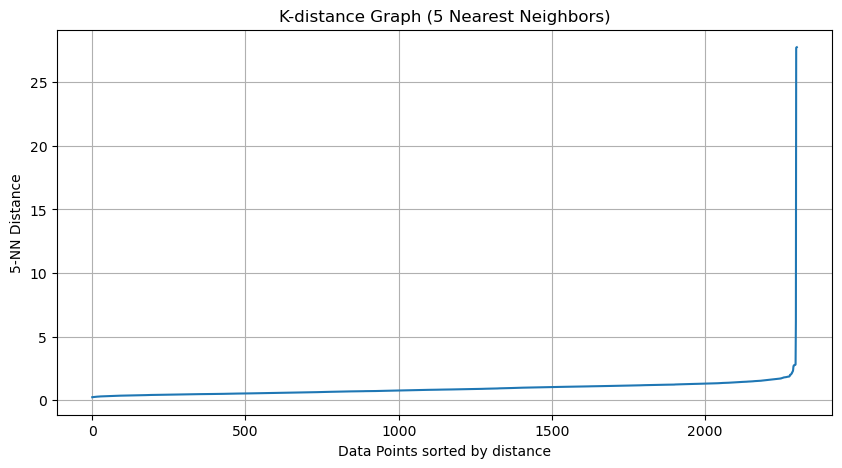

In [28]:

# K-distance graph for eps estimation
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_preprocessed)
distances, indices = neighbors_fit.kneighbors(X_preprocessed)

# Sort and plot k-distances
k_distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title('K-distance Graph (5 Nearest Neighbors)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5-NN Distance')
plt.grid(True)
plt.show()


- The elbow around distance ≈ **1.0** suggests that points beyond this threshold are in sparser regions — good candidates for cluster separation.


### Apply DBSCAN

- DBSCAN is applied to the scaled insurance data.
- Points are grouped into clusters; outliers are labeled `-1`.

- Clusters are plotted using PCA-reduced dimensions.
- Red X's represent **centroids** of each cluster (computed manually).


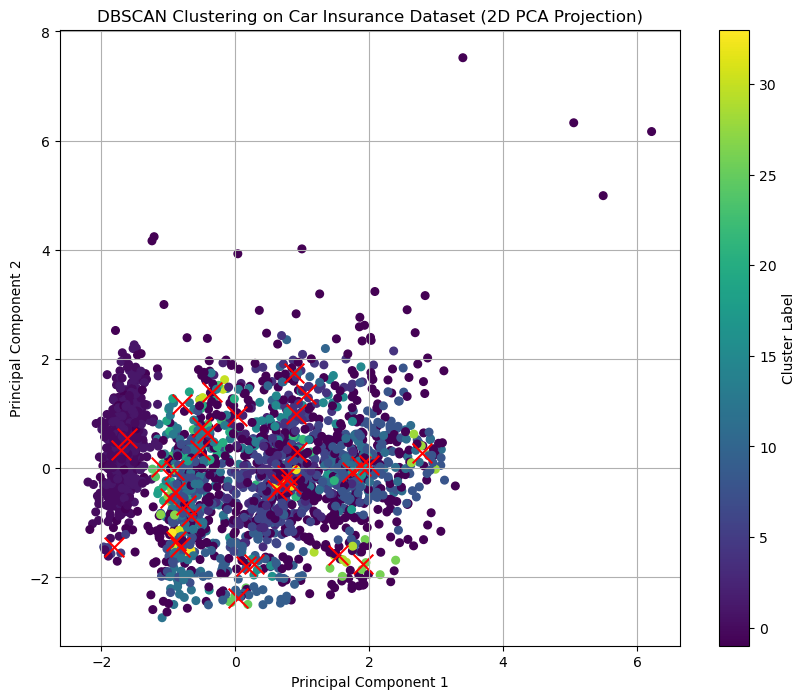

In [29]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5, algorithm='auto')
labels = dbscan.fit_predict(X_preprocessed)

# PCA scatter plot with DBSCAN labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30)


# Plot cluster centroids manually (mean of points)
unique_labels = set(labels)
for label in unique_labels:
    if label != -1:
        cluster_points = X_pca[labels == label]
        centroid = cluster_points.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=200)

plt.colorbar(scatter, label='Cluster Label')
plt.title("DBSCAN Clustering on Car Insurance Dataset (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Points are projected into 2D for visualization.
- Colors represent clusters, and red X's show manually computed cluster centroids.
- Many points are labeled `-1` (outliers), showing DBSCAN had **difficulty finding meaningful clusters** in this data.

### Summary Stats (Insurance)
- Total number of **valid clusters** and **noise points** are counted.
- A histogram shows the **distribution of points per cluster**.


num clusters 34
num noise 627


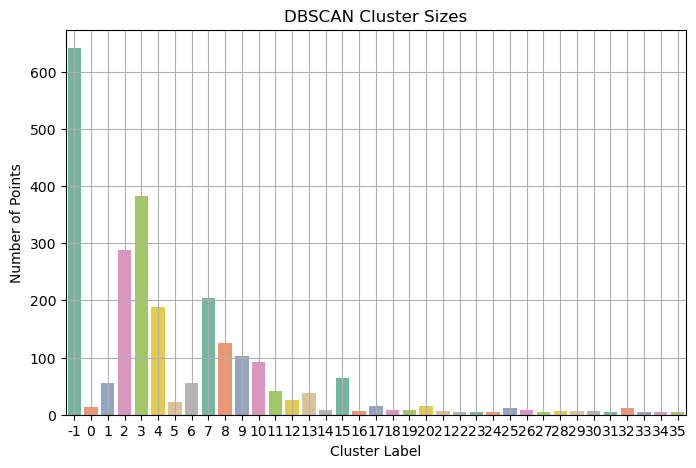

In [30]:
# Summary Stats
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_noise = list(labels).count(-1)


print('num clusters', num_clusters)
print('num noise', num_noise)

#  Cluster count histogram
plt.figure(figsize=(8, 5))
sns.countplot(x=labels_cross, palette='Set2')
plt.title("DBSCAN Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.grid(True)
plt.show()



- Confirms that **most points are noise** (`label = -1`), and the remaining clusters are small.
- Suggests **DBSCAN struggled** to identify dense regions in the scaled insurance dataset.

## Apply DBSCAN to Wholesale Dataset

### Data Processing

- We load the wholesale customer dataset and keep only numeric features.
- Scaling ensures equal weight across features.
- PCA enables 2D visualization of clusters.


In [31]:

# Load the Wholesale dataset
df = pd.read_csv("../Datasets/Wholesale.csv")

# Inspect and drop non-numeric or identifier columns if present
df = df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

###  Estimate `eps` with K-distance

- A sorted plot of the 5-nearest-neighbor distances guides selection of `eps`.


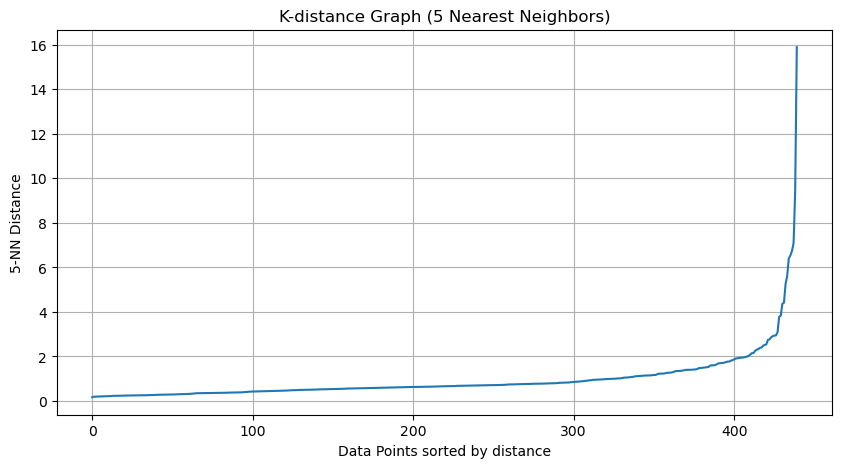

In [32]:

# K-distance graph to estimate eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the distances
k_distances = np.sort(distances[:, 4])
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title('K-distance Graph (5 Nearest Neighbors)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5-NN Distance')
plt.grid(True)
plt.show()

- This version shows a clearer elbow at **eps ≈ 1.2**, indicating well-separated dense regions.
- A good visual cue that DBSCAN may work better on this dataset.

### Apply DBSCAN to Wholesale Data

- DBSCAN segments the data; outliers are labeled `-1`.
- Visualizes clusters in PCA space.
- Red X's show centroids.

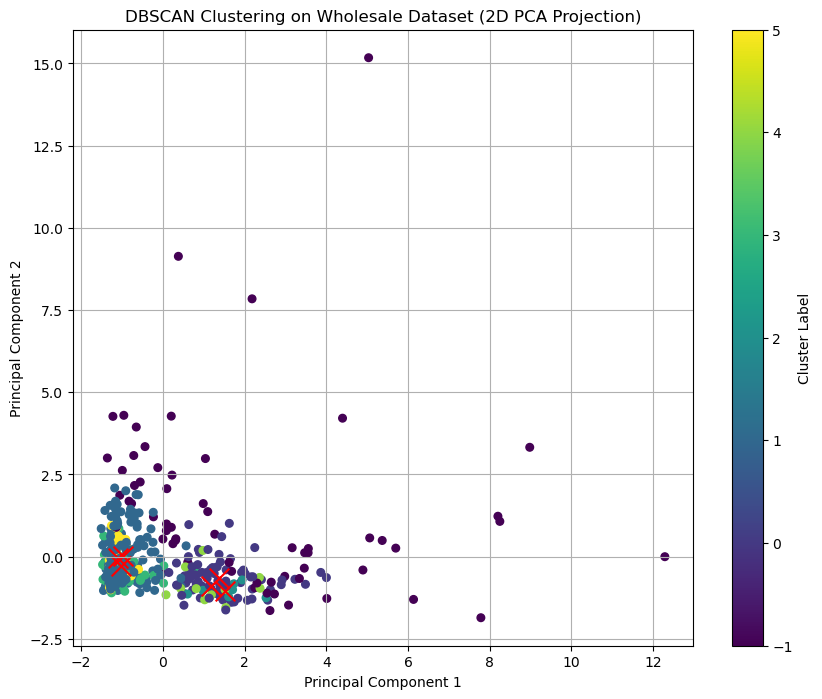

In [33]:

# Apply DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5)  # eps is based on visual inspection of k-distance
labels = dbscan.fit_predict(X_scaled)

# DBSCAN cluster visualization in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30)
unique_labels = set(labels)
for label in unique_labels:
    if label != -1:
        cluster_points = X_pca[labels == label]
        centroid = cluster_points.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=200)
plt.colorbar(scatter, label='Cluster Label')
plt.title("DBSCAN Clustering on Wholesale Dataset (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

- Well-defined clusters are visible.
- Outliers are fewer compared to the insurance dataset.
- Cluster centroids are shown with red X's.

The wholesale dataset appears to have **naturally separable, dense clusters** that DBSCAN can detect effectively.


### Summary Stats (Wholesale)

- Counts number of clusters and outliers.
- Shows bar chart of cluster sizes.

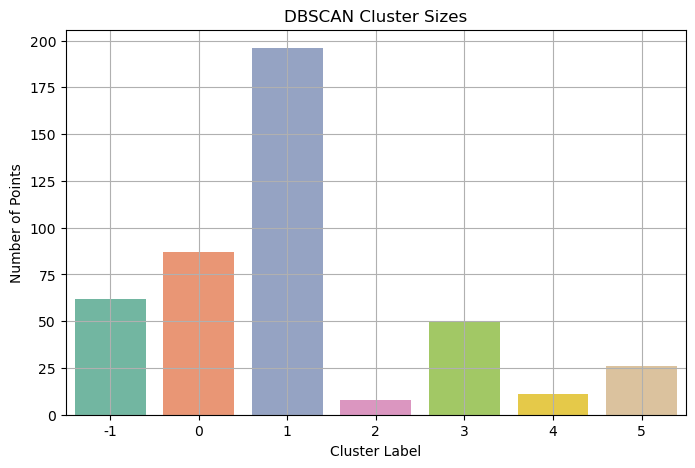

In [34]:

# Summary
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_noise = list(labels).count(-1)
num_clusters, num_noise

# Histogram of cluster sizes
plt.figure(figsize=(8, 5))
sns.countplot(x=labels, palette='Set2')
plt.title("DBSCAN Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.grid(True)
plt.show()

- We can see that most clusters are balanced.
- Fewer noise points than the insurance dataset.


### Silhouette Score and Comparison

- Computes **Silhouette Score** for DBSCAN (excluding noise).
- **KMeans (k=3)** is used as a baseline for comparison.

- Higher silhouette = better-defined clusters.
- Useful to justify DBSCAN vs KMeans effectiveness.


In [35]:

# Silhouette score for DBSCAN (exclude noise)
mask = labels != -1
dbscan_silhouette = silhouette_score(X_scaled[mask], labels[mask]) if np.sum(mask) > 1 else None

# KMeans for comparison
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print('DBSCAN sillouette', dbscan_silhouette)
print('K means sillouette', kmeans_silhouette)


DBSCAN sillouette 0.2487554529284867
K means sillouette 0.3567685389017652


- DBSCAN Silhouette ≈ 0.25 → Low cluster separation, can be useful.
- KMeans Silhouette ≈ 0.36 → Moderate separation; better than DBSCAN on this data.

## Conclusion and Business Insights

We applied DBSCAN to two datasets:
- **Car Insurance Data**: DBSCAN struggled, returning mostly noise and poorly defined clusters.
- **Wholesale Data**: DBSCAN performed well, discovering compact, high-density clusters.


### Limitations

- DBSCAN is **highly sensitive** to the `eps` parameter and the scale of features.
- It performs poorly on datasets without well-defined dense regions (e.g., normalized insurance data).
- PCA visualization is **approximate**; real clustering happens in higher dimensions.
- Clustering results are **not interpretable** without deeper profiling of cluster contents.

### Future Steps

- Profile each DBSCAN cluster (avg. features, customer types) for real-world interpretability.
- Use **HDBSCAN**, a hierarchical extension of DBSCAN, for better cluster handling.
- Try **isolation-based methods** (e.g., Isolation Forest) for outlier detection in sparse data.

### Practical Implications

- For **insurance applications**, DBSCAN may not be suitable unless there are clear spatial or behavioral clusters.
- However, it **works well** for customer segmentation in domains like **retail/wholesale**, where customers exhibit natural purchasing clusters.
- DBSCAN is ideal for **fraud detection**, **anomaly detection**, and **geospatial clustering** — but less effective on uniformly distributed, scaled tabular data.
